### <span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Kinetic_fit00<br>
This nootebook solve for $k_{1}$ to $k_{7}$ simultaneously using non-linear least squares fitting.

In [1]:
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from IPython.display import display, Math

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Read and show raw data:

In [2]:
df = pd.read_csv('kinetic_raw.csv')
df

,Time (min),A0,A1,A2,A3,A4,A5,A6
0,0.00,10043.380,0.000,0.000,0.000,0.000,0.000,0.000
1,0.25,4934.811,1222.983,221.920,46.536,60.536,113.364,0.000
2,0.50,3293.933,1933.397,410.941,64.364,90.950,164.192,0.000
3,1.00,1665.397,2432.497,912.548,171.849,127.778,296.263,0.000
4,2.00,441.941,2123.841,1757.841,477.406,244.849,656.941,0.000
5,3.00,135.849,1345.255,2108.598,859.062,513.870,1120.184,79.021
6,4.00,79.192,892.719,1968.719,1056.941,597.991,1499.841,92.435
7,5.00,0.000,408.284,1520.255,1211.355,992.062,2555.497,163.920
8,10.00,0.000,0.000,222.849,608.941,758.598,2464.841,207.577


#### <span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Normalization (fraction of intermediate):<br>
<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">The following equation was used to normalize data as shown in Figure 1 C : https://doi.org/10.1016/j.cell.2011.05.010<br>
$$ A_i(t) = \frac{A_i(t)}{\sum_{i=0}^{n} A_i(t)} $$

In [3]:
df = pd.concat([df['Time (min)'],df.iloc[:,1:].div(df.iloc[:,1:].sum(axis=1), axis=0)], axis=1)
df

,Time (min),A0,A1,A2,A3,A4,A5,A6
0,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.25,0.747682,0.185296,0.033623,0.007051,0.009172,0.017176,0.000000
2,0.50,0.552880,0.324517,0.068976,0.010803,0.015266,0.027559,0.000000
3,1.00,0.297056,0.433884,0.162771,0.030653,0.022792,0.052844,0.000000
4,2.00,0.077495,0.372419,0.308241,0.083714,0.042935,0.115196,0.000000
5,3.00,0.022047,0.218320,0.342203,0.139416,0.083396,0.181794,0.012824
6,4.00,0.012798,0.144270,0.318159,0.170809,0.096640,0.242385,0.014938
7,5.00,0.000000,0.059592,0.221891,0.176805,0.144798,0.372990,0.023925
8,10.00,0.000000,0.000000,0.052278,0.142850,0.177957,0.578220,0.048695


### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">Solving for k<sub>1</sub> ... k<sub>7</sub> using A0 ... A6
<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Create a python function to calculate </span>$A_0$:
$$ A_0(t) = e^{-k_1t} $$

In [4]:
def A_0(t, k1, k2, k3, k4, k5, k6, k7):
    return np.exp(-t*k1)

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Build python function mimicing the equation:
$$ A_i(t) = \prod_{j=1}^i k_j \sum_{j=1}^{i+1} \frac{e^{-k_jt}}{\prod_{p=1,p\neq j}^{i+1}(k_p-k_j)} \qquad i=1...n $$

In [5]:
def A_i(t, *k_values):
    """
    Calculates A_i(t) for a given set of k values (k1, k2, ..., k_(i+1)).
    Designed for use with scipy.optimize.curve_fit.

    Args:
        t: Time variable.
        *k_values: Variable number of rate constants (k1, k2, ..., k_(i+1)).

    Returns:
        The value of A_i(t).
        Returns np.nan if any two k values are equal to avoid division by zero.

    Raises:
        ValueError: If the number of k_values is less than 2.

    """


    n = len(k_values)  # n=i in A_i

    if not 2 <= n:
        raise ValueError("The number of k_values must be higher than 2.")

    i = n - 1 

    product_k = np.prod(k_values[:i])
    sum_terms = 0

    for j in range(i + 1):
        numerator = np.exp(-k_values[j] * t)
        denominator = 1
        for p in range(i + 1):
            if p != j:
                denominator *= (k_values[p] - k_values[j])
        # denominator = 1e-8 if abs(denominator) < 1e-8 else denominator # bypass dividing by zero
        sum_terms += numerator / denominator

    return product_k * sum_terms

--------------

In [6]:
t = df['Time (min)']
A_ = [df['A0'], df['A1'], df['A2'], df['A3'], df['A4'], df['A5'], df['A6']]

In [7]:
def A_1(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2)

def A_2(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2, k3)

def A_3(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2, k3, k4)

def A_4(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2, k3, k4, k5)

def A_5(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2, k3, k4, k5, k6)

def A_6(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2, k3, k4, k5, k6, k7)

functions = [A_0, A_1, A_2, A_3, A_4, A_5, A_6]

In [8]:
# Objective function for minimization (sum of squared residuals for all functions)
def objective_function(params):
    """Calculates the sum of squared residuals for all functions."""
    residuals = []
    for A, func in zip(A_, functions):
        residuals.extend(A - func(t, *params)) #extend the list of all residuals so the function finds best parameters
    return np.sum(np.array(residuals)**2)

# Initial guess for shared parameters from recursive method
initial_guess = [1.2065, 0.7285, 0.5515, 0.9445, 1.0465, 0.1015, 1.1875]

# Fitting
result = minimize(objective_function, initial_guess)
parms = result.x

for i in range(len(parms)):
    display(Math(f'k_{{{i+1}}} = {parms[i]:.3f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Plot fitted parameters:

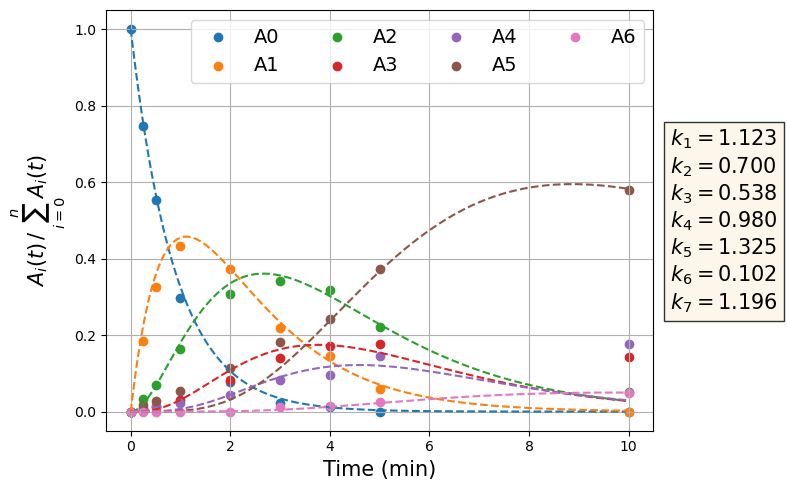

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
labels = ['A0','A1', 'A2', 'A3','A4', 'A5', 'A6']

for A, func, color, label in zip(A_, functions, colors, labels):
    ax.scatter(t, A, label=label, color=color)
    ax.plot(np.arange(0,10,0.05), func(np.arange(0,10,0.05), *parms), '--', color=color)

textstr = '\n'.join([f'$k_{{{i+1}}} = {val:.3f}$' for i, val in enumerate(parms)])  
props = dict(boxstyle='square', facecolor='oldlace', alpha=0.8)  
ax.text(1.03, 0.72, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

ax.set_xlabel("Time (min)", fontsize=15)
ax.set_ylabel(r'${A_i(t)}\,/\,{\sum_{i=0}^{n} A_i(t)}$', fontsize=15)
ax.legend(ncol=4, fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()